<a href="https://colab.research.google.com/github/deadshotbane80/LeNet-5-Implementation-in-Pytorch./blob/main/LeNet_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
'''In this case for transforms i am not using for transforms.v2 which is the latest version in pytorch'''
import torch,torchvision
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.datasets as Datasets

In [28]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
print(f'Using device = {device}')

Using device = cpu


In [29]:
transforms_train = T.Compose([T.ToTensor(),
                        T.Resize((32,32)),
                        T.Normalize(mean = (0.1307,),std = (0.3081,))])
transforms_test = T.Compose([T.ToTensor(),
                        T.Resize((32,32)),
                        T.Normalize(mean = (0.1325,),std = (0.3104,))])

In [44]:
batch_size = 64
NUM_TRAIN = 59000
train = Datasets.MNIST(root = 'data',
                       train = True,
                       transform = transforms_train,
                       download = True)
train_data = DataLoader(train,batch_size,sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
val = Datasets.MNIST(root = 'data',
                      train = True,
                      transform = transforms_train,
                      download = True,
                          )
val_data = DataLoader(val,batch_size,sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN,60000)))
test = Datasets.MNIST(root = 'data',
                     train = False,
                     transform = transforms_test,
                     download = True)
test_data = DataLoader(test,batch_size,shuffle = True)

In [5]:
print(f'Min value = {train.data.min()}')
print(f'Max value = {train.data.max()}')
print(f'Mean  = {train.data.float().mean()}')
print(f'Std deviation = {train.data.float().std()}')
print(f'scaled mean = {train.data.float().mean()/255}')
print(f'scaled std = {train.data.float().std()/255}')

Min value = 0
Max value = 255
Mean  = 33.31842041015625
Std deviation = 78.56748962402344
scaled mean = 0.13066047430038452
scaled std = 0.30810779333114624


In [6]:
#Same for test data
print(f'Min value = {test.data.min()}')
print(f'Max value = {test.data.max()}')
print(f'Mean  = {test.data.float().mean()}')
print(f'Std deviation = {test.data.float().std()}')
print(f'scaled mean = {test.data.float().mean()/255}')
print(f'scaled std = {test.data.float().std()/255}')

Min value = 0
Max value = 255
Mean  = 33.79122543334961
Std deviation = 79.17247009277344
scaled mean = 0.1325146108865738
scaled std = 0.3104802668094635


In [34]:
for x,y in train_data:
  print(x.shape,y.shape)
  break

torch.Size([64, 1, 32, 32]) torch.Size([64])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [36]:
len(train_data),len(val_data),len(test_data)

(922, 16, 938)

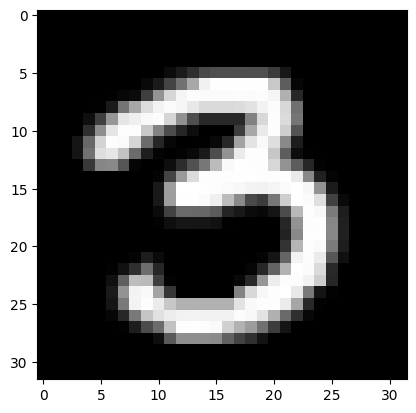

In [37]:
import matplotlib.pyplot as plt
plt.imshow(x[0].squeeze(),cmap = 'gray')
plt.show()

In [39]:
def test_model(loader,model):
  if loader.dataset.train:
        print('Checking accuracy on val set')
  else:
        print('Checking accuracy on test set')
  num_correct = 0
  num_samples = 0
  model.eval()
  with torch.no_grad():
    for x,y in loader:
      x = x.to(device)
      y = y.to(device)
      logits = model(x)
      pred = logits.argmax(1)
      num_correct += (pred == y).sum()
      num_samples += len(pred)
    acc = float(num_correct)/num_samples
    print(f'Got {num_correct}/{num_samples} correct {100*acc:.4f} ')

In [40]:
def train_model(loader,model,optimizer,epochs = 1):
  model = model.to(device)
  for e in range(epochs):
    for t,(x,y) in enumerate(loader):
      model.train()
      x = x.to(device)
      y = y.to(device)
      logits = model(x)
      loss = F.cross_entropy(logits,y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if t % accuracy_interval == 0:
        print(f'Epoch = {e + 1}')
        print(f'Iteration {t} , loss {loss.item():.4f}')
        test_model(val_data,model)
        print()


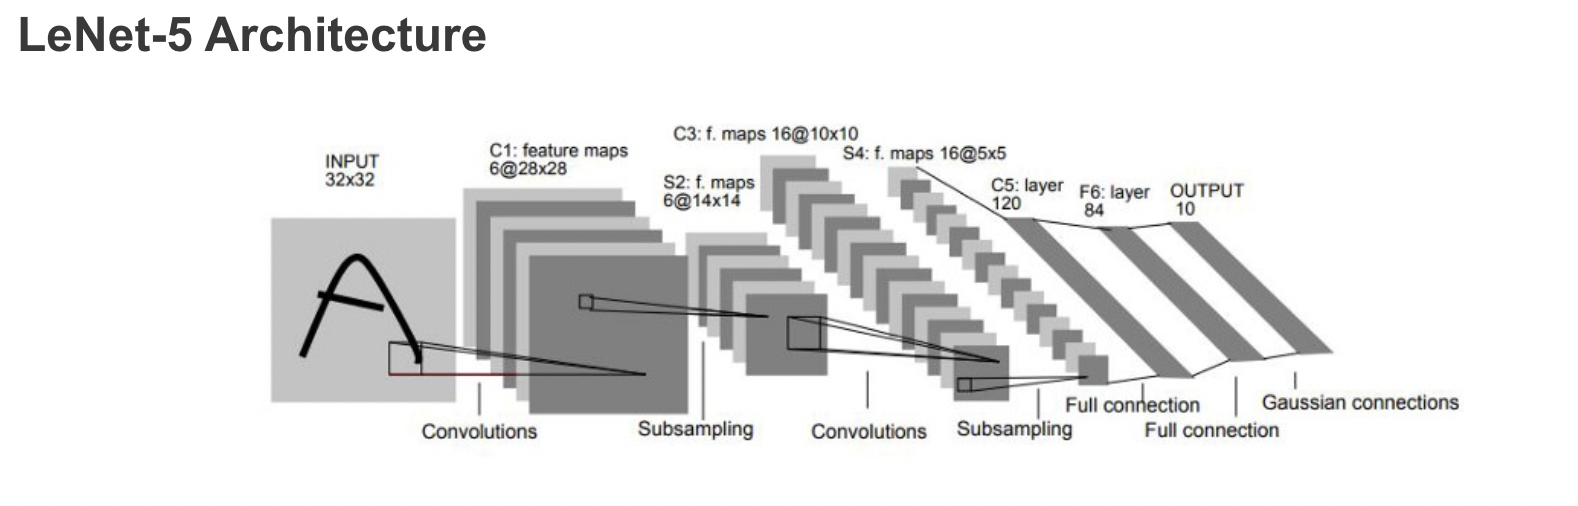

In [41]:
'''Lets implement the lenet 5 architecture from lecun papers(1996) it work on orignally 32 x 32 pixels with architecture as follows
   Layer 1 = contains 6 feature maps or filters(5 x 5),1 stride
   ReLU
   Pooling of 2 x 2 by a stride of 2
   Layer 2 = contains 16 feature maps or filters(10 x 10),1 stride
   ReLU
   Pooling of 2 x 2 by a stride of 2
   Layer 3 = contains 120 feature maps or filters(5 x 5) ,1 stride
   ReLU
   Layer 4 = Is fully connected layer with 84 hiddend units
   ReLU '''

class LeNet(nn.Module):
   def __init__(self,):
      super().__init__()
      self.C1 = nn.Conv2d(1,6,5,1)
      nn.init.kaiming_normal_(self.C1.weight)
      self.S2 = nn.MaxPool2d(2,2)
      self.C3 = nn.Conv2d(6,16,5,1)
      nn.init.kaiming_normal_(self.C3.weight)
      self.C5 = nn.Conv2d(16,120,5,1)
      nn.init.kaiming_normal_(self.C5.weight)
      self.fcl1 = nn.Linear(120,84)
      nn.init.kaiming_normal_(self.fcl1.weight)
      self.fcl2 = nn.Linear(84,10)
      nn.init.kaiming_normal_(self.fcl2.weight)
   def forward(self,x):
      x = F.relu(self.C1(x))
      x = self.S2(x)
      x = F.relu(self.C3(x))
      x = self.S2(x)
      x = F.relu(self.C5(x))
      x = torch.flatten(x,1)
      x = F.relu(self.fcl1(x))
      x = self.fcl2(x)
      return x
model = LeNet()
optimizer = torch.optim.SGD(model.parameters(),lr = 1e-3)
train_model(train_data,model,optimizer,epochs = 10)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch = 1
Iteration 0 , loss 6.0590
Checking accuracy on val set
Got 29/1000 correct 2.9000 

Epoch = 1
Iteration 300 , loss 0.8267
Checking accuracy on val set
Got 811/1000 correct 81.1000 

Epoch = 1
Iteration 600 , loss 0.3966
Checking accuracy on val set
Got 896/1000 correct 89.6000 

Epoch = 1
Iteration 900 , loss 0.3673
Checking accuracy on val set
Got 917/1000 correct 91.7000 

Epoch = 2
Iteration 0 , loss 0.3270
Checking accuracy on val set
Got 923/1000 correct 92.3000 

Epoch = 2
Iteration 300 , loss 0.2931
Checking accuracy on val set
Got 925/1000 correct 92.5000 

Epoch = 2
Iteration 600 , loss 0.3297
Checking accuracy on val set
Got 936/1000 correct 93.6000 

Epoch = 2
Iteration 900 , loss 0.1323
Checking accuracy on val set
Got 946/1000 correct 94.6000 

Epoch = 3
Iteration 0 , loss 0.1727
Checking accuracy on val set
Got 945/1000 correct 94.5000 

Epoch = 3
Iteration 300 , loss 0.1716
Checking accuracy on val set
Got 946/1000 correct 94.6000 

Epoch = 3
Iteration 600 , lo

In [45]:
test_model(test_data,model)

Checking accuracy on test set


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Got 9697/10000 correct 96.9700 
